# Using Machine Learning to Predict Resume Callbacks #

## Background and Context ## 

This analysis is uses data that is leveraged from Philip Oreopoulos and his academic paper - ["Why Do Skilled Immigrants Struggle in the Labor Market? A Field Experiment with Thirteen Thousand Resumes.](https://pubs.aeaweb.org/doi/pdfplus/10.1257/pol.3.4.148)" 

The main question Oreopoulos aims to answer is why do skilled immigrants have trouble finding work in Canada. He takes artificially generated resumes with various names that indicate the individual's ethnicity in order to further investigate this issue. These resumes are numerically ranked based on their features. These features include speaking/writing ability, technical experience, notable references, and educational background.

Oreopoulos finds that there was a significant influence on the background of names on the resume and whether they received a callback. 

I am interested in applying this data to machine learning algorithims to understand that when faced with new inputs - would a similar result surface? Would users that have names that are more ethnic in the Canadian labour market have a lower probability of a callback? What features are the most important when building the ML model?

### Cleaning and Feature Engineering ###

In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("max_columns", 100)

In [2]:
# Read in data from Philip Oreopoulos
df = pd.read_stata(
    "~/Documents/Python Code/Resume_Experiment_Analysis/data/oreopoulos resume study replication data file.dta")
print("Number of Rows:{}".format(len(df)))
print("Number of Columns:{}".format(len(df.columns)))
print("Number of NA:{}".format((df.isnull().sum().sum())))


Number of Rows:12910
Number of Columns:31
Number of NA:62191


### Exploding and Recoding Data  ###

In [3]:
# Change columns to interger binary columns (hot one encode)
df['canada'] = (df['name_ethnicity']  == 'Canada').astype(int)
df['greek'] = (df['name_ethnicity']  == 'Greek').astype(int)
df['Chn_Cdn'] = (df['name_ethnicity']  == 'Chn-Cdn').astype(int)
df['indian'] = (df['name_ethnicity'] == 'Indian').astype(int)
df['british'] = (df['name_ethnicity'] == 'British').astype(int)
df['pakistani'] = (df['name_ethnicity'] == 'Pakistani').astype(int)
df['chinese'] = (df['name_ethnicity'] == 'Chinese').astype(int)
df['female'] = (df['female'].astype(int))
df['callback'] = (df['callback'].astype(int))
df['same_exp'] = df['same_exp'].fillna(0).astype(int)
df['reference'] = df['reference'].fillna(0).astype(int)
df['accreditation'] = df['accreditation'].fillna(0).astype(int)
df['legal'] = df['legal'].fillna(0).astype(int)
df['extracurricular_skills'] = df['extracurricular_skills'].fillna(0).astype(int)

For this current data-set I exploded the data from the initial ethnicity name category. I made categories for Canadian, Greek, Chinese Canadian, Indian, British, Pakistani, and Chinese names. I also filled NAs with zero from the replication instructions from Oreopoulos' replication. 

In [4]:
df.head()

,firmid,occupation_type,name_ethnicity,additional_credential,name,language_skills,accreditation,reference,legal,listedaccreditation,city,ma,female,certificate,ba_quality,exp_highquality,callback,interview,second_callback,type,extracurricular_skills,skillspeaking,skillsocialper,skillwriting,fall_data,chinese,indian,british,pakistani,Chn_Cdn,same_exp,canada,greek
0,-3,Administrative,Canada,0.0,JillWilson,0.0,0,0,0,0.0,Toronto,0.0,1,0.0,1.0,0.0,0,0.0,0.0,0.0,0,70.0,50.0,67.0,2.0,0,0,0,0,0,0,1,0
1,-3,Administrative,Indian,0.0,PanavSingh,0.0,0,0,0,0.0,Toronto,0.0,0,0.0,1.0,0.0,0,0.0,0.0,1.0,0,70.0,50.0,67.0,2.0,0,1,0,0,0,0,0,0
2,-3,Administrative,Indian,0.0,RahulKaur,0.0,0,0,1,1.0,Toronto,0.0,0,0.0,0.0,0.0,0,0.0,0.0,4.0,1,70.0,50.0,67.0,2.0,0,1,0,0,0,0,0,0
3,-3,Administrative,Chinese,0.0,LeiLi,0.0,1,1,0,1.0,Toronto,0.0,0,0.0,0.0,0.0,0,0.0,0.0,3.0,1,70.0,50.0,67.0,2.0,1,0,0,0,0,0,0,0
4,-4,Administrative,Indian,0.0,MayaKumar,1.0,0,0,0,0.0,Toronto,0.0,1,0.0,1.0,0.0,0,0.0,0.0,3.0,0,80.0,70.0,65.0,2.0,0,1,0,0,0,0,0,0


In [6]:
df1 = df.drop(columns = ['firmid', 'additional_credential', 'interview', 'second_callback', 'type'])

In [7]:
# Occupation Type Groupings

non_technical = ['Administrative', 'Executive Assistant', 'Marketing and Sales', 'Human Resources Payroll',
                'Food Services Managers', 'Retail', 'Insurance', 'Ecommerce', 'Clerical', 'Social Worker', 
                'Media and Arts', 'Executive Assisstant']

In [8]:
# group into jobs that are considired non-technical and technical
df1["non_technical"] = np.where(df1["occupation_type"].isin(non_technical), 1, 0)
df1["technical"] = np.where(df1["non_technical"] == 1, 0, 1)

I decided to sort the jobs into technical and non-technical jobs to see if this makes a difference when working with feature engineering and selection. Are the consolidated features correlated with callback rate?

In [9]:
df1.select_dtypes(include=['int64', 'float64', 'float32']).aggregate(['min', 'max', 'mean', 'median'])

,language_skills,accreditation,reference,legal,listedaccreditation,ma,female,certificate,ba_quality,exp_highquality,callback,extracurricular_skills,skillspeaking,skillsocialper,skillwriting,fall_data,chinese,indian,british,pakistani,Chn_Cdn,same_exp,canada,greek,non_technical,technical
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
max,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,93.000000,94.000000,93.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000
mean,0.245546,0.03842,0.026491,0.037103,0.212519,0.169868,0.508675,0.009373,0.537723,0.311619,0.099613,0.601704,69.576878,59.550128,64.000775,1.112858,0.220604,0.259721,0.070798,0.074129,0.112006,0.254454,0.234392,0.02835,0.599303,0.400697
median,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,70.000000,62.000000,66.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000


In [10]:
# Merging Name Backgrounds 

df1['east_asian'] = ((df1['name_ethnicity']  == 'Chn-Cdn') | (df1['name_ethnicity'] == 'Chinese')).astype(int)
df1['south_asian'] = ((df1['name_ethnicity']  == 'Indian') | (df1['name_ethnicity'] == 'Pakistani')).astype(int)
df1['anglo'] = ((df1['name_ethnicity']  == 'British') | (df1['name_ethnicity'] == 'Canada')).astype(int)

In [11]:
print(df1['anglo'].value_counts())
print(df1['east_asian'].value_counts())
print(df1['south_asian'].value_counts())

0    8970
1    3940
Name: anglo, dtype: int64
0    8616
1    4294
Name: east_asian, dtype: int64
0    8600
1    4310
Name: south_asian, dtype: int64


I decided to merge name backgrounds ino 3 bins so that variance among features is decreased. From above I decided to bin names by anglo-saxon names (Canadian and British), east asian names (Chinese and Chinese Canadian), and south asian (Indian and Pakistani). The bins have a similarly equal distribution of ~ 4000 observations each. 

In [12]:
df2 = df1.drop(columns = ['canada', 'Chn_Cdn', 'non_technical', 
                          'british', 'chinese', 'greek', 'pakistani', 
                          'indian', 'occupation_type', 'fall_data', 'listedaccreditation'])

In [13]:
# sepearate observations by location
df2['vancouver'] = ((df2['city']  == '')).astype(int)
df2['toronto'] = ((df2['city']  == 'Toronto')).astype(int)
df2['montreal'] = ((df2['city']  == 'Montreal')).astype(int)

In [14]:
print(df2.columns[df2.isna().any()].tolist())
print(df['skillspeaking'].isna().sum())
print(df['skillsocialper'].isna().sum())
print(df['skillwriting'].isna().sum())

['skillspeaking', 'skillsocialper', 'skillwriting']
13
13
13


In [15]:
df2 = df2[(df2["skillspeaking"] > 0) & (df2["skillsocialper"] > 0) & (df2["skillwriting"] > 0)]

In [16]:
df2.columns

Index(['name_ethnicity', 'name', 'language_skills', 'accreditation',
       'reference', 'legal', 'city', 'ma', 'female', 'certificate',
       'ba_quality', 'exp_highquality', 'callback', 'extracurricular_skills',
       'skillspeaking', 'skillsocialper', 'skillwriting', 'same_exp',
       'technical', 'east_asian', 'south_asian', 'anglo', 'vancouver',
       'toronto', 'montreal'],
      dtype='object')

In [17]:
df3 = df2.dropna()

In [19]:
print(abs(df3.corr()['callback']).sort_values(ascending = False))

callback                  1.000000
anglo                     0.077218
toronto                   0.063559
montreal                  0.053698
south_asian               0.041687
skillspeaking             0.040691
east_asian                0.034142
female                    0.032169
language_skills           0.024485
reference                 0.022557
accreditation             0.017787
exp_highquality           0.015945
skillsocialper            0.015682
legal                     0.015650
technical                 0.013164
vancouver                 0.012681
same_exp                  0.011732
ma                        0.011401
skillwriting              0.008162
certificate               0.005319
extracurricular_skills    0.004081
ba_quality                0.001697
Name: callback, dtype: float64


After dropping columns I thought were not relevant to the analysis and providing appropriate constraints to variables I created a correlation list for features in relation to the callback variable. From the initial correlation, it looks like anglo-saxon names are correlated with the callback variable. Variables that I might want to include are the name variables, skill speaking, female, and the location variables due to personal interest.

In [20]:
delete_1 = ['exp_highquality', 'legal', 'technical',
         'same_exp', 'ma', 'skillwriting', 'certificate', 
            'extracurricular_skills', 'ba_quality', 'name', 'city', 
            'name_ethnicity', 'accreditation', 'reference', 'language_skills']
combined1 = df3.drop(columns=[col for col in df3 if col in delete_1])
combined1.dropna(inplace=True)

In [21]:
combined1.columns

Index(['female', 'callback', 'skillspeaking', 'skillsocialper', 'east_asian',
       'south_asian', 'anglo', 'vancouver', 'toronto', 'montreal'],
      dtype='object')

In [22]:
def rescale(values, new_min = 0, new_max = 100):
    output = []
    old_min, old_max = min(values), max(values)

    for v in values:
        new_v = (new_max - new_min) / (old_max - old_min) * (v - old_min) + new_min
        output.append(new_v)

    return output

In [23]:
combined1['skillspeaking'] = rescale(combined1['skillspeaking'])
combined1['skillsocialper'] = rescale(combined1['skillsocialper'])

The skill speaking and the skill social variables are scaled in a manner where the lowest value is ~ 30 and the highest value is ~ 94. I decided to rescale these variables from a normal 0 - 100 scale for easier interpretation

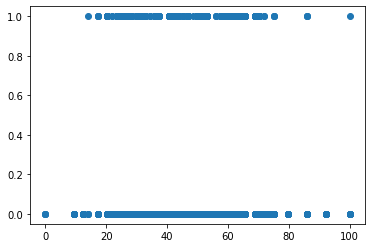

In [24]:
plt.scatter(combined1['skillsocialper'], combined1['callback'])
plt.show()

In [25]:
combined1['skillsocialper'].describe()

count    12893.000000
mean        46.201427
std         14.473435
min          0.000000
25%         31.250000
50%         50.000000
75%         53.125000
max        100.000000
Name: skillsocialper, dtype: float64

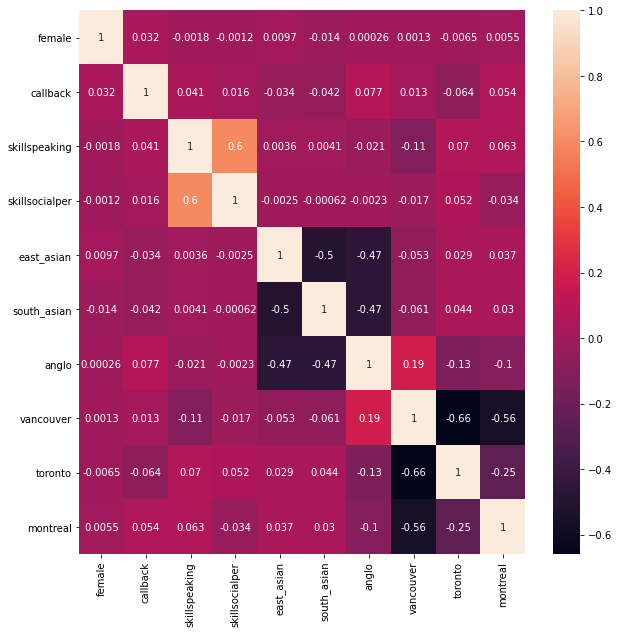

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap((combined1.corr()), annot = True, ax=ax)
plt.show()

I plotted a correlation matrix to see how the variables that I engineered and selected compare to each other. From the matrix there is a low correlation between many variables. This may indicate that the variables do not have a strong dependence or relationship with each other. However notable variables such as skill speaking and skill social have a value of 0.6 which is moderately positively correlated. 

Variables are not correlated with each other and this may indicate outside noise or randomness that is not being explained from the selected variables. However for the purpose of this analysis, I will look into fitting a ML model with the available data.

In [27]:
combined1.to_csv('data/combined1.csv', index = False)

### EDA and Visual Exploration ###

Text(0.5, 1.0, 'Name Ethnicity Frequency')

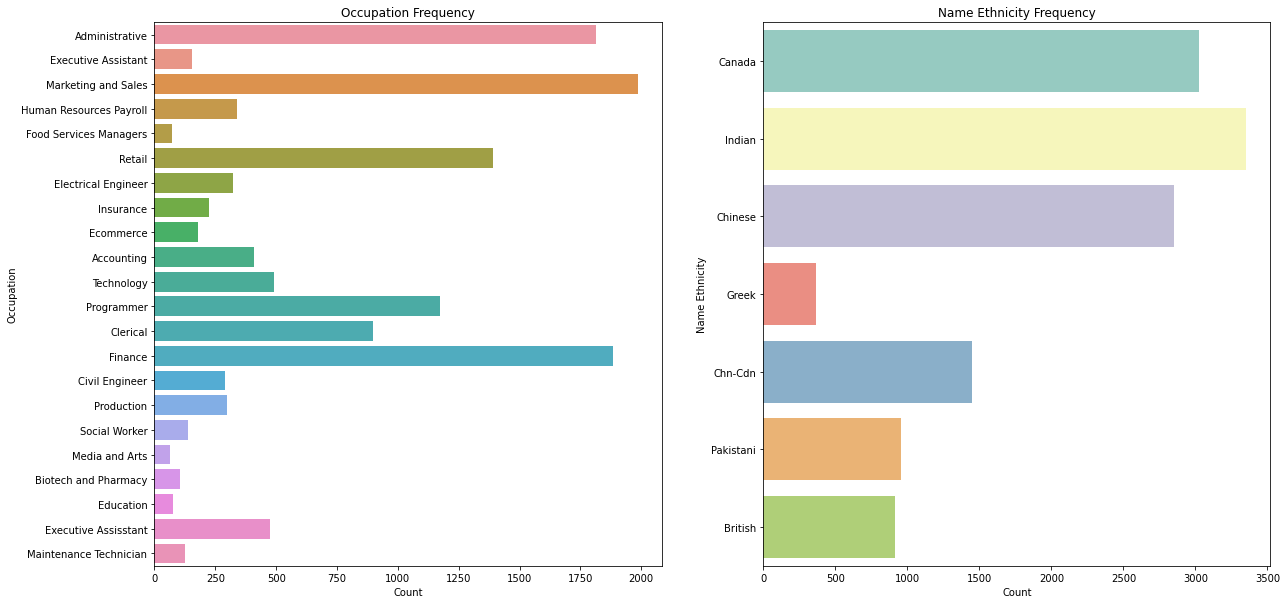

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(20,10))
sns.countplot(y="occupation_type", ax=ax[0], data=df)
sns.countplot(y="name_ethnicity", ax=ax[1], palette='Set3', data=df)
ax[0].set_title('Occupation Frequency')
ax[0].set_ylabel('Occupation')
ax[0].set_xlabel('Count')
ax[1].set_ylabel('Name Ethnicity')
ax[1].set_xlabel('Count')
ax[1].set_title('Name Ethnicity Frequency')

Text(0.5, 0, 'Count')

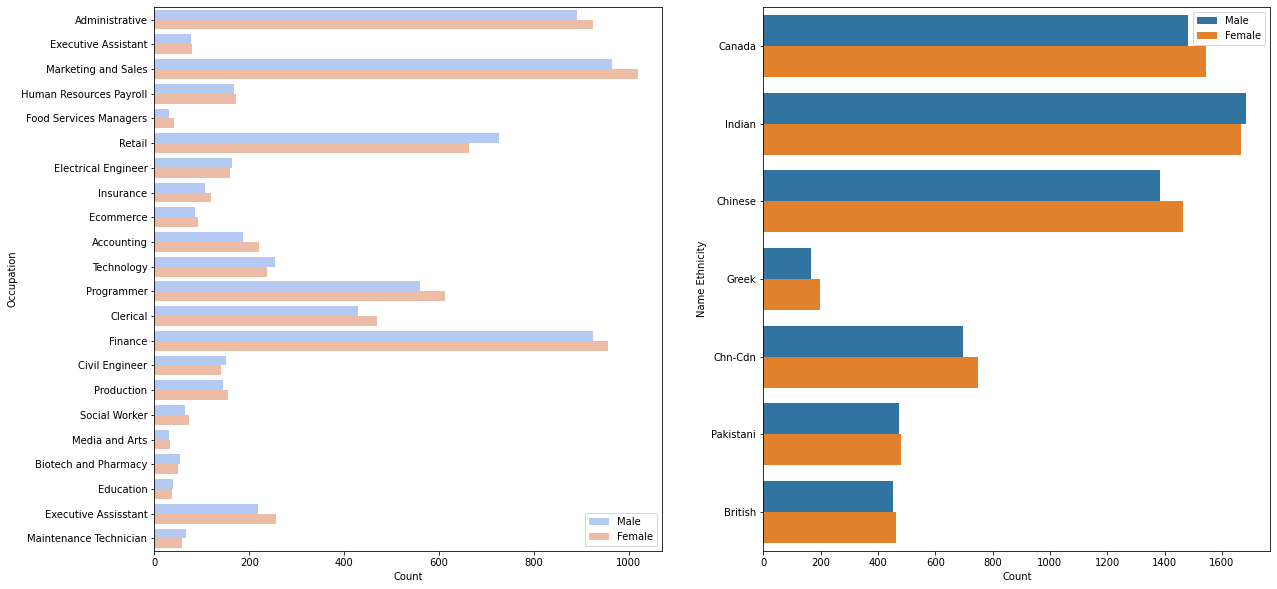

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
sns.countplot(y="occupation_type", hue = 'female', palette='coolwarm', ax=ax1, data=df)
sns.countplot(y="name_ethnicity", hue = 'female', ax=ax2, data=df)
ax1.legend(["Male", "Female"])
ax2.legend(["Male", "Female"])
ax1.set_ylabel('Occupation')
ax1.set_xlabel('Count')
ax2.set_ylabel('Name Ethnicity')
ax2.set_xlabel('Count')

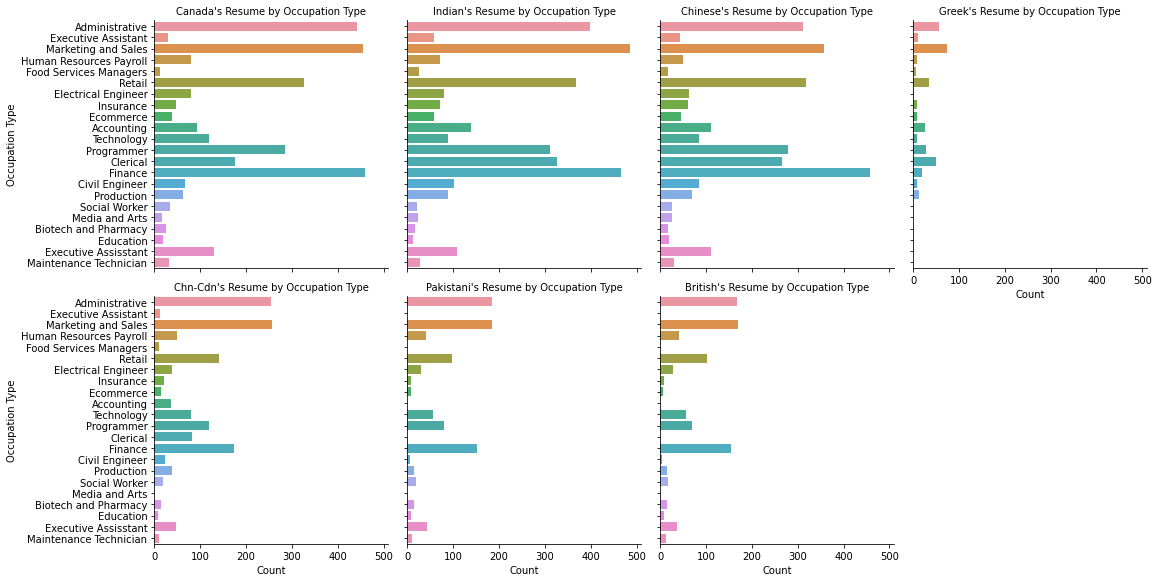

In [25]:
g = sns.catplot(y="occupation_type", col="name_ethnicity",
                data=df, kind="count",
                height=4, col_wrap=4);

g.set_titles(col_template="{col_name}'s Resume by Occupation Type")
g.set_axis_labels("Count", "Occupation Type")